<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>
<p> Download training_variants.zip and training_text.zip from Kaggle.</p> 

<h6> Context:</h6>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462</p>

<h6> Problem statement : </h6>
<p> Classify the given genetic variations/mutations based on evidence from text-based clinical literature. </p>

<h2>1.2. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h3>2.1.2. Example Data Point</h3>

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ... 

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Reduce the CV and test log-loss to a value less than 1.0
</p>
<p> Constraints:
</p>
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

<h1>3. Exploratory Data Analysis</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


C:\Users\hp\Downloads\temp\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [2]:
data = pd.read_csv(r'C:\Users\hp\Downloads\variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>3.1.2. Reading Text Data</h3>

In [3]:

data_text =pd.read_csv(r"C:\Users\hp\Downloads\text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of text</h3>

In [4]:

stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 267.9543816378734 seconds


In [9]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')


<h3>3.1.4. Analysis On Text ,Gene, Class && Variation</h3>

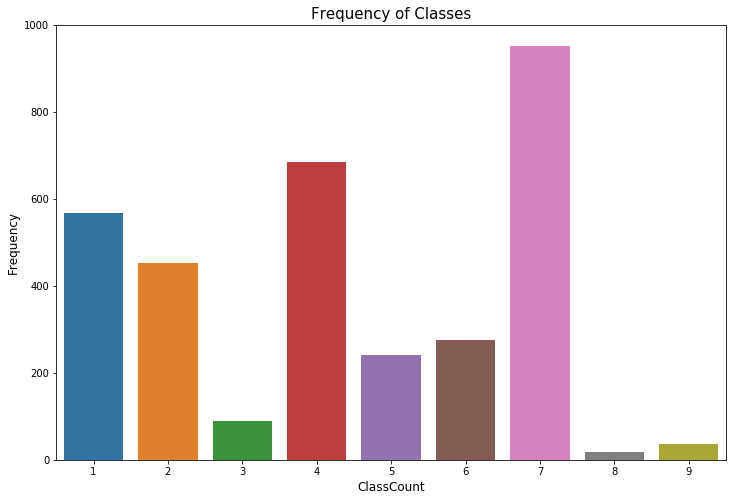

In [11]:
# How is the Class distribution ?
def plot_feature_frequency(feature):
    plt.figure(figsize=(12,8))
    sns.countplot(x=feature, data=result)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(feature+'Count', fontsize=12)
    plt.xticks(rotation='horizontal')
    plt.title("Frequency of Classes", fontsize=15)
    plt.show()

#Plot the class frequency in the train dataset
plot_feature_frequency("Class")

<p> It is imbalance dataset having most of them belong to class 7</p>

In [12]:
#Length of train text entry 
#Define a feature as the number of words by text feature
result["Text_num_words"] = result["TEXT"].apply(lambda x: len(str(x).split()) )

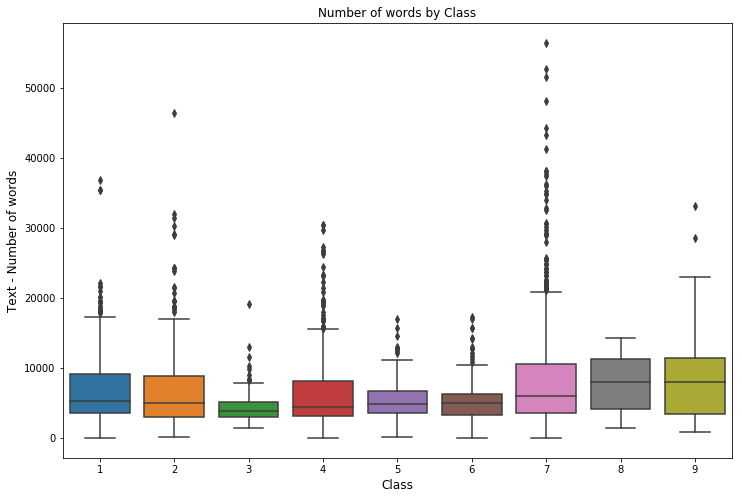

In [13]:
#Plot the number of words distribution for each class in combined text
plt.figure(figsize=(12,8))
sns.boxplot(x='Class', y='Text_num_words', data=result)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.title('Number of words by Class')
plt.show()

In [15]:
max(result["Text_num_words"])


56425

<p> The longer text is built with 56425 words.  we have very long text that should be time consuming for researcher.</p>

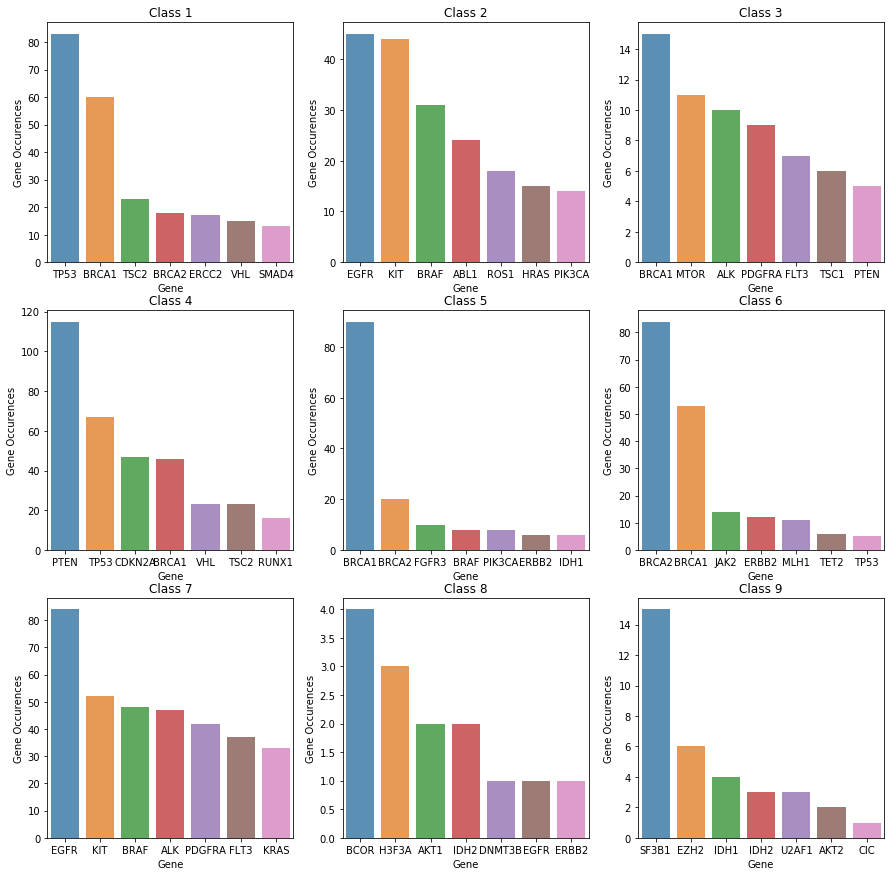

In [16]:
#How is the Gene distribution by Class ?
fig, axis = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

#For each class get the 7 most popular gene
for i in range(3):
    for j in range(3):
        train_class_ij = result[result['Class']==((i*3+j)+1)]   #Select the rows associated at the current class in the inner loop
        gene_pivot_df = train_class_ij.pivot_table(index="Gene", values="ID", aggfunc=lambda x: len(x)).reset_index()   #Count the number of occurences for each Gene     
        gene_pivot_df = gene_pivot_df.sort_values('ID', ascending=False)[:7]
        sns.barplot(x="Gene", y="ID", data=gene_pivot_df, alpha=0.8, ax=axis[i][j])
        axis[i][j].set(xlabel='Gene', ylabel='Gene Occurences', title= "Class "+str((i*3+j)+1))

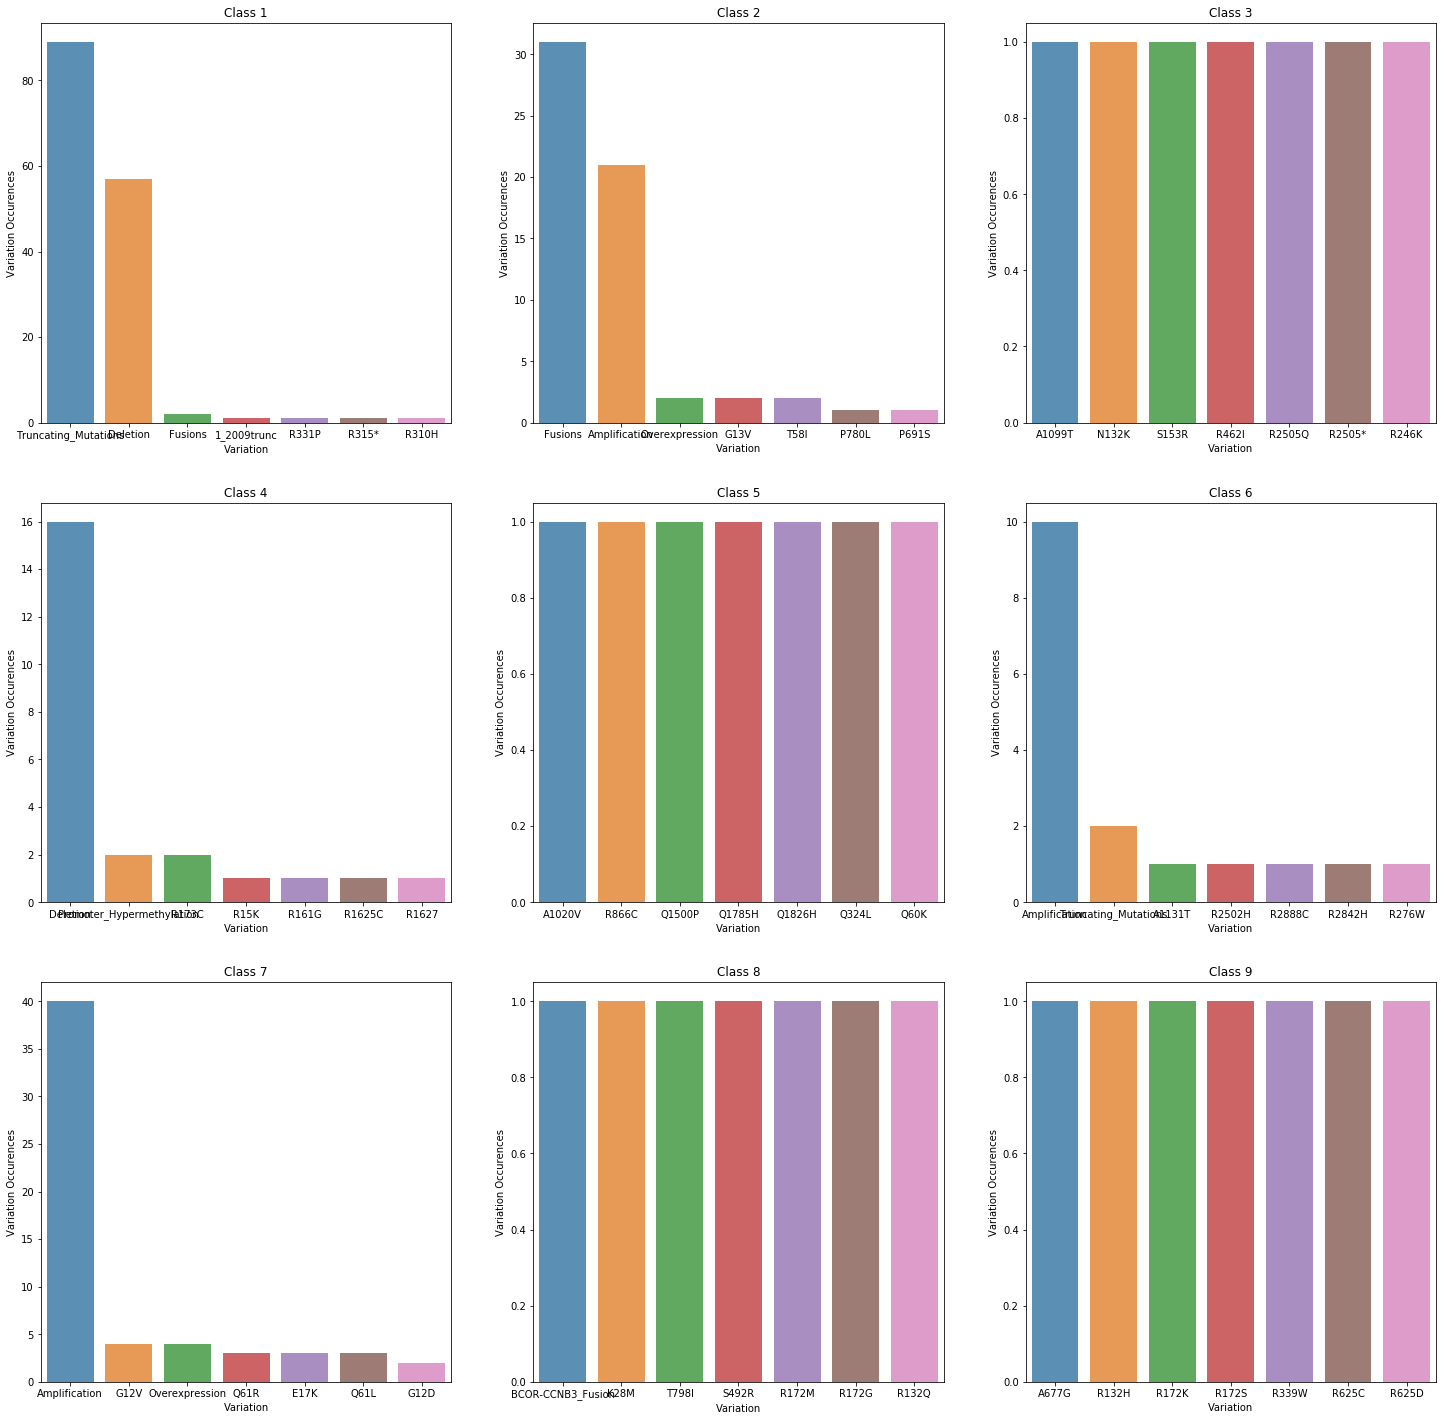

In [19]:
#How is the Gene distribution by Class ?
fig, axis = plt.subplots(ncols=3, nrows=3, figsize=(25,25))

#For each class get the 7 most popular gene
for i in range(3):
    for j in range(3):
        train_class_ij = result[result['Class']==((i*3+j)+1)]   #Select the rows associated at the current class in the inner loop
        gene_pivot_df = train_class_ij.pivot_table(index="Variation", values="ID", aggfunc=lambda x: len(x)).reset_index()   #Count the number of occurences for each Gene     
        gene_pivot_df = gene_pivot_df.sort_values('ID', ascending=False)[:7]
        sns.barplot(x="Variation", y="ID", data=gene_pivot_df, alpha=0.8, ax=axis[i][j])
        axis[i][j].set(xlabel='Variation', ylabel='Variation Occurences', title= "Class "+str((i*3+j)+1))

<h1> 4.1 TF-IDf and Feature Selection

In [20]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3),min_df = 5,max_features = 50000)
final_tf_idf = tf_idf_vect.fit_transform(result['TEXT'].values)

In [21]:
final_tf_idf.shape

(3321, 50000)

In [24]:
svd = TruncatedSVD(n_components=750, n_iter=7, random_state=42)
SVD_text = svd.fit_transform(final_tf_idf)


In [116]:
SVD_text.shape

(3321, 750)

In [25]:
SVD_text = pd.DataFrame(SVD_text)

<h1> 4.1 One-Hot Encoding </h1>

<h5> Gene and Variation is Categorial Feature So we convert it into One-Hot Encoding </h5>

In [29]:
Gene_dummie = pd.get_dummies(result['Gene'].values)

In [30]:
Gene_dummie.head(2)

,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,AR,ARAF,...,TSC1,TSC2,U2AF1,VEGFA,VHL,WHSC1,WHSC1L1,XPO1,XRCC2,YAP1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
Variation_dummie = pd.get_dummies(result['Variation'].values)

In [32]:
Variation_dummie.head(2)

,1_2009trunc,2010_2471trunc,256_286trunc,3'_Deletion,385_418del,422_605trunc,533_534del,534_536del,550_592del,560_561insER,...,Y87N,Y901C,Y931C,Y98H,Y98N,YAP1-FAM118B_Fusion,YAP1-MAMLD1_Fusion,ZC3H7B-BCOR_Fusion,ZNF198-FGFR1_Fusion,p61BRAF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
temp = pd.concat([Gene_dummie,Variation_dummie],axis =1)

In [34]:
X = pd.concat([temp,SVD_text],axis = 1)

In [35]:
X.head(1)

,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,AR,ARAF,...,740,741,742,743,744,745,746,747,748,749
0,0,0,0,0,0,0,0,0,0,0,...,-0.009953,0.014989,-0.047781,-0.021154,-0.002466,0.018578,-0.011292,0.024049,0.043269,-0.030203


<h3>4.2 Test, Train and Cross Validation Split</h3>

<h4>4.2.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [36]:
y_true = result['Class'].values

X_train, test_df, y_train, y_test = train_test_split(X, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<h1>5. Machine Learning Models</h1>

In [37]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
  
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [38]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [39]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [42]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<h2>5.1. Base Line Model</h2>

<h2>5.1.1 K-NN</h2>

for alpha = 4
Log Loss : 1.0765232453997904
for alpha = 5
Log Loss : 1.0698625413583844
for alpha = 6
Log Loss : 1.0702402698508982
for alpha = 7
Log Loss : 1.0774799629817529
for alpha = 8
Log Loss : 1.08511474663944
for alpha = 9
Log Loss : 1.0935967077264455


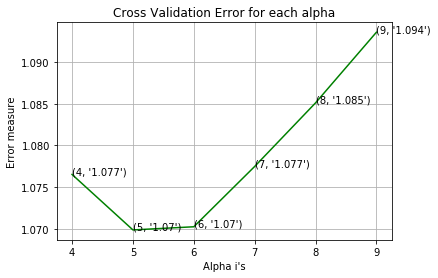

For values of best alpha =  5 The train log loss is: 0.9092331570919717
For values of best alpha =  5 The cross validation log loss is: 1.0698625413583844
For values of best alpha =  5 The test log loss is: 1.0501696238386549


In [41]:

alpha = [4, 5, 6, 7, 8, 9]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_df,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.0698625413583844
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


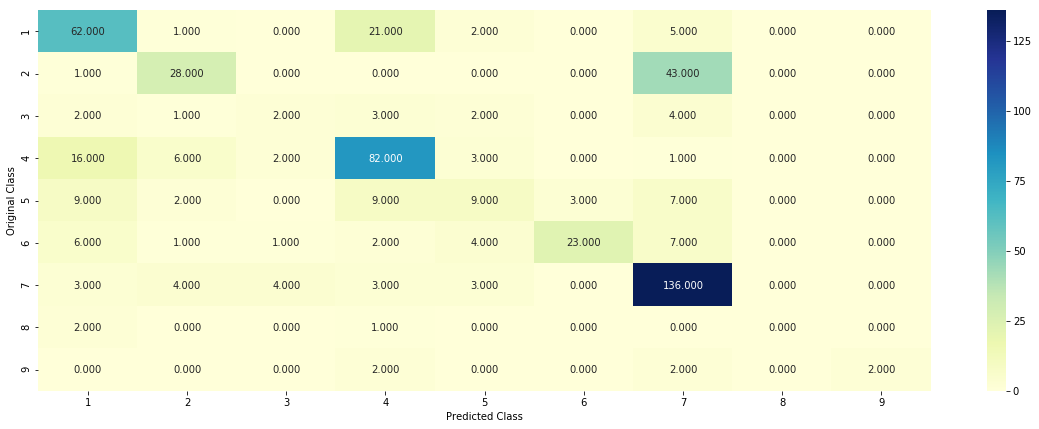

-------------------- Precision matrix (Columm Sum=1) --------------------


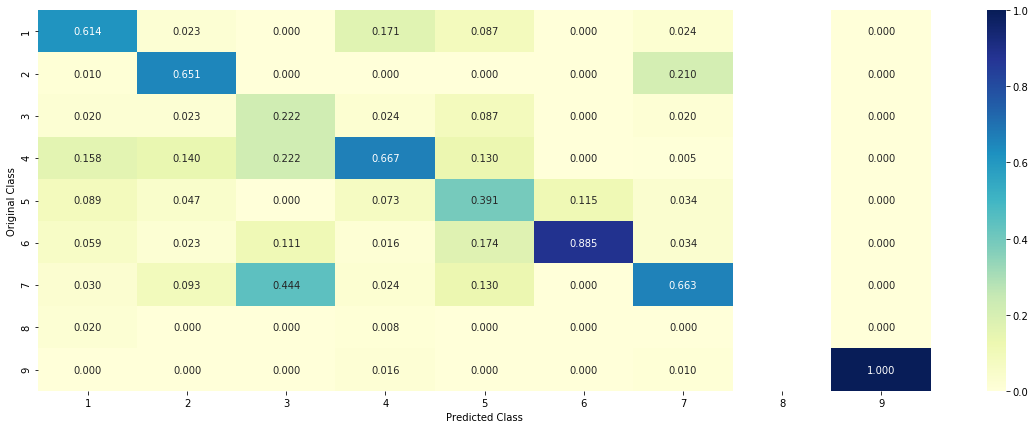

-------------------- Recall matrix (Row sum=1) --------------------


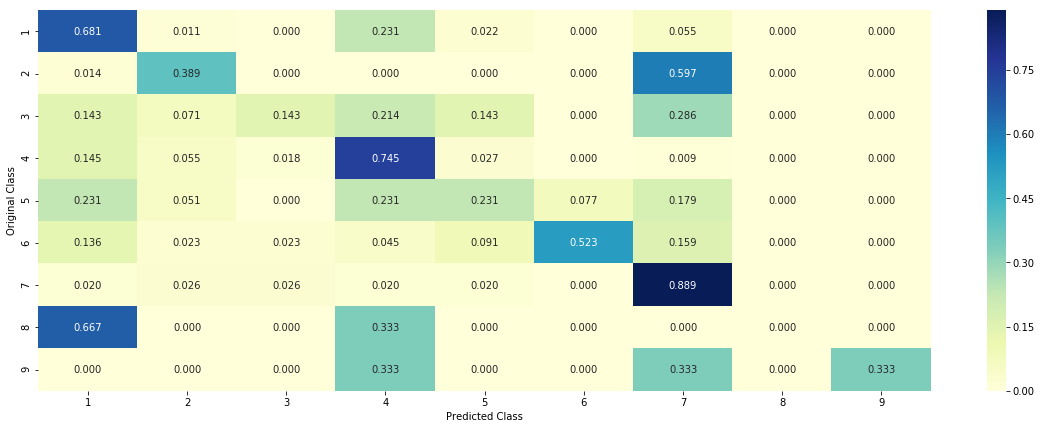

In [43]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_df,y_train, cv_df, y_cv, clf)

<h2>5.1.2 Logistic Regression with class balacing</h2>

for alpha = 1e-06
Log Loss : 1.021551410187002
for alpha = 1e-05
Log Loss : 1.0147289209465935
for alpha = 0.0001
Log Loss : 0.9569198584139991
for alpha = 0.001
Log Loss : 1.0071219698736864
for alpha = 0.01
Log Loss : 1.155798128561733
for alpha = 0.1
Log Loss : 1.218464157668686
for alpha = 1
Log Loss : 1.2278128807119357
for alpha = 10
Log Loss : 1.357884321652697
for alpha = 100
Log Loss : 1.418201826909214


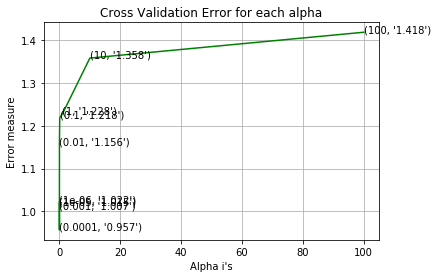

For values of best alpha =  0.0001 The train log loss is: 0.4601506331642956
For values of best alpha =  0.0001 The cross validation log loss is: 0.9569198584139991
For values of best alpha =  0.0001 The test log loss is: 0.9227448217540741


In [46]:
#logistic regression
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.9569198584139991
Number of mis-classified points : 0.3101503759398496
-------------------- Confusion matrix --------------------


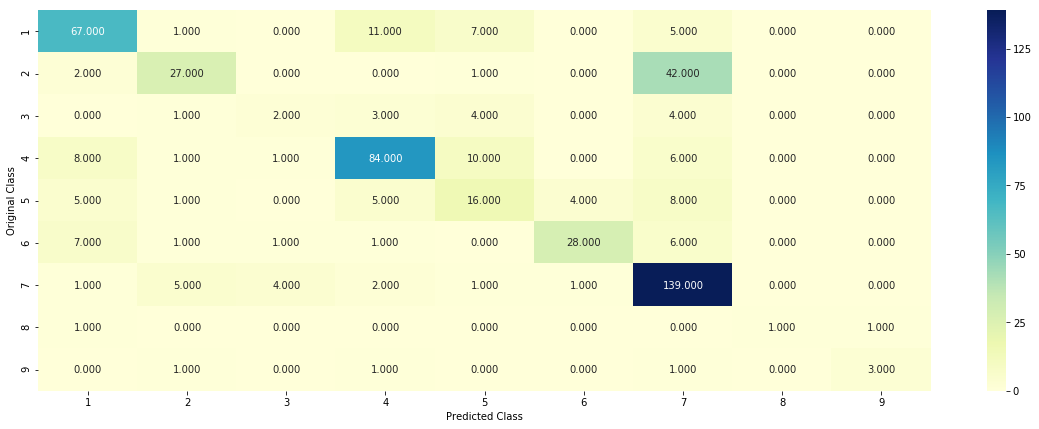

-------------------- Precision matrix (Columm Sum=1) --------------------


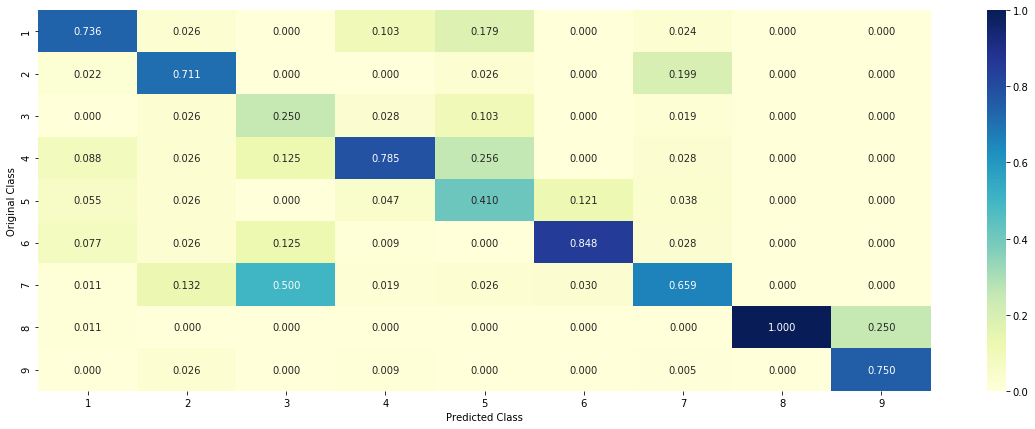

-------------------- Recall matrix (Row sum=1) --------------------


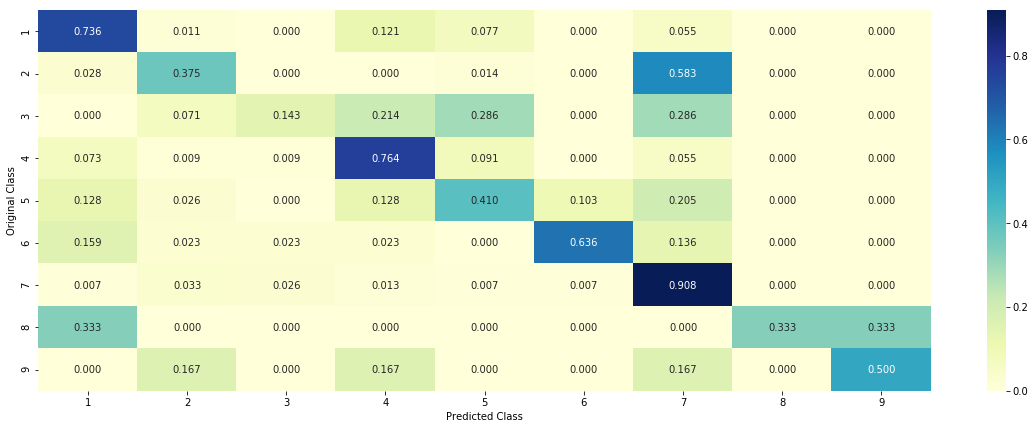

In [47]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_df, y_train, cv_df, y_cv, clf)

<h2>5.1.3 Logistic Regression without class balacing</h2>

for alpha = 1e-06
Log Loss : 1.0209331580045276
for alpha = 1e-05
Log Loss : 1.0006571567468967
for alpha = 0.0001
Log Loss : 0.9569039601475274
for alpha = 0.001
Log Loss : 0.9954894619765629
for alpha = 0.01
Log Loss : 1.1395032442530308
for alpha = 0.1
Log Loss : 1.2163464389190148
for alpha = 1
Log Loss : 1.2519031045959246


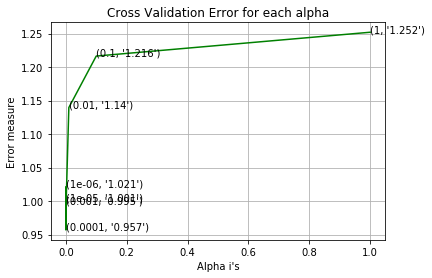

For values of best alpha =  0.0001 The train log loss is: 0.45107460188838316
For values of best alpha =  0.0001 The cross validation log loss is: 0.9569039601475274
For values of best alpha =  0.0001 The test log loss is: 0.9286319267484396


In [48]:


alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.9569039601475274
Number of mis-classified points : 0.31390977443609025
-------------------- Confusion matrix --------------------


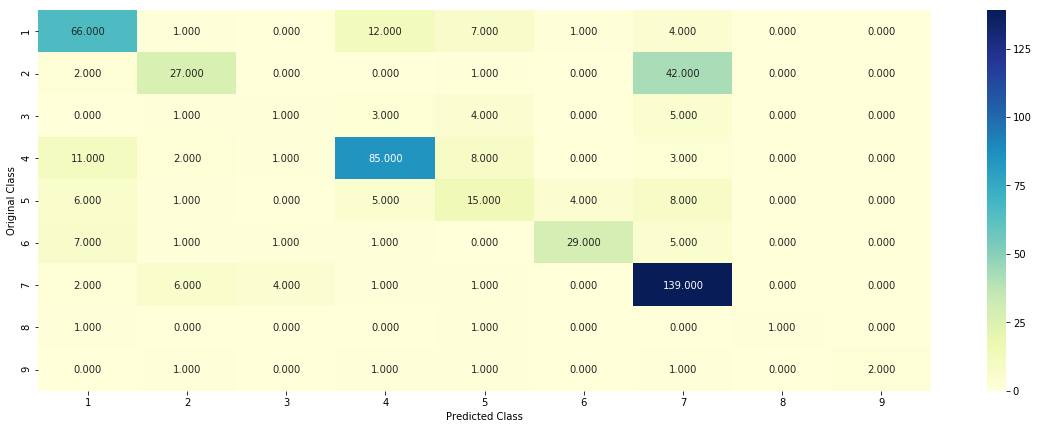

-------------------- Precision matrix (Columm Sum=1) --------------------


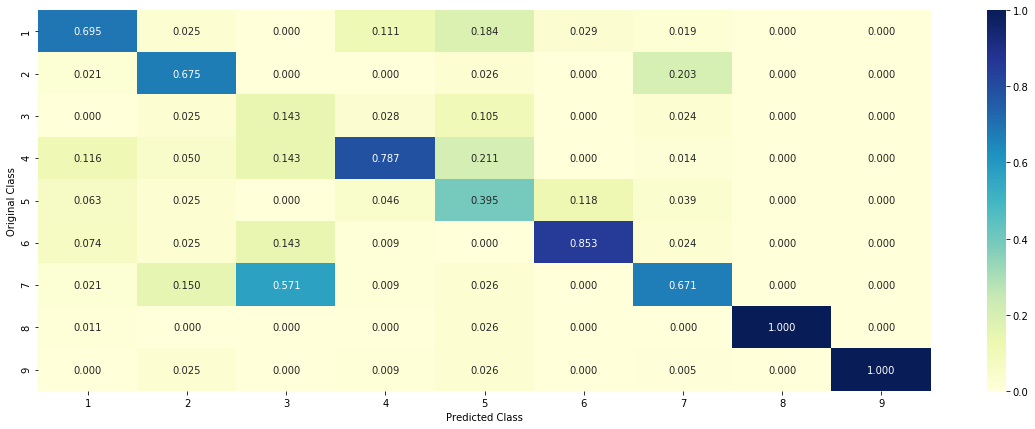

-------------------- Recall matrix (Row sum=1) --------------------


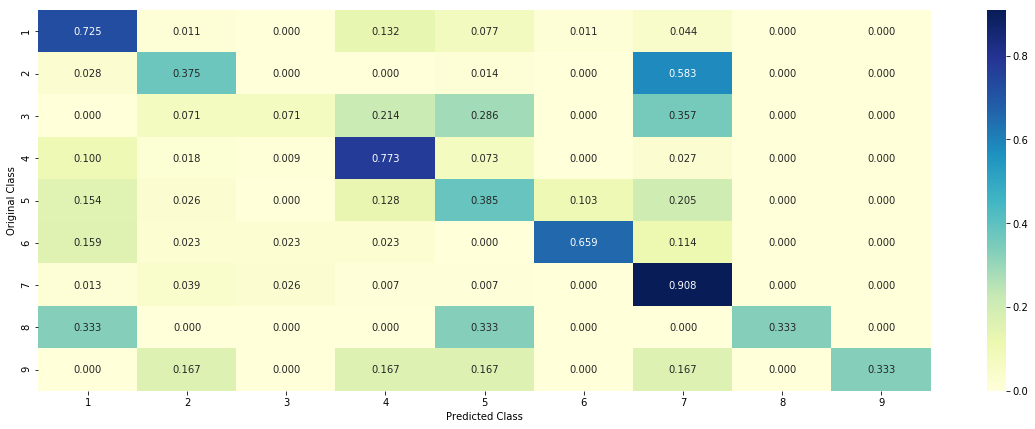

In [49]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_df, y_train, cv_df, y_cv, clf)

<h2>5.1.4 Logistic Regression with L1 penalty </h2>

for alpha = 1e-06
Log Loss : 1.0433800154737387
for alpha = 1e-05
Log Loss : 1.026224662348716
for alpha = 0.0001
Log Loss : 0.9930423693859907
for alpha = 0.001
Log Loss : 1.1572338371511417
for alpha = 0.01
Log Loss : 1.5632727422318158
for alpha = 0.1
Log Loss : 1.8302599804888027
for alpha = 1
Log Loss : 1.8302599805080688
for alpha = 10
Log Loss : 1.8302599809247149
for alpha = 100
Log Loss : 1.8302599806429702


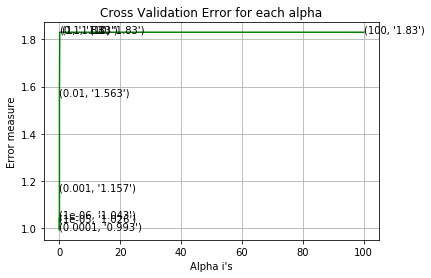

For values of best alpha =  0.0001 The train log loss is: 0.5428255366946232
For values of best alpha =  0.0001 The cross validation log loss is: 0.9930423693859907
For values of best alpha =  0.0001 The test log loss is: 0.9805874944670925


In [50]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.9930423693859907
Number of mis-classified points : 0.30451127819548873
-------------------- Confusion matrix --------------------


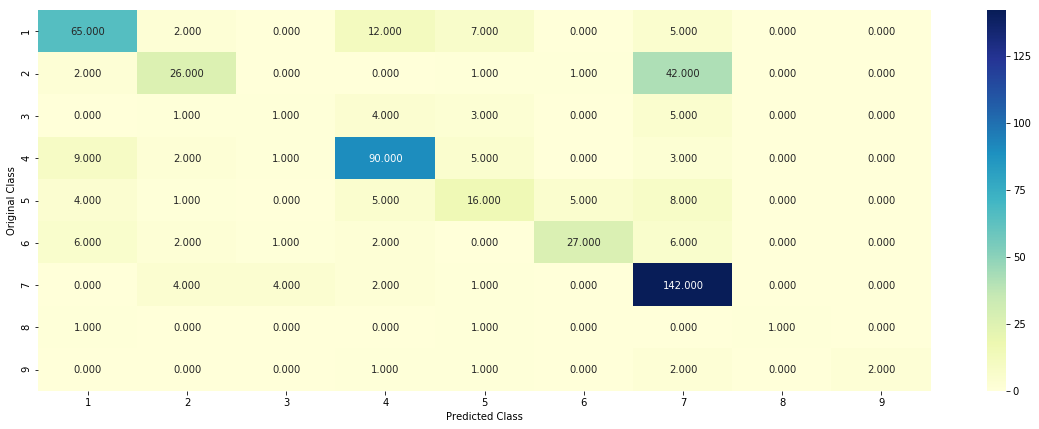

-------------------- Precision matrix (Columm Sum=1) --------------------


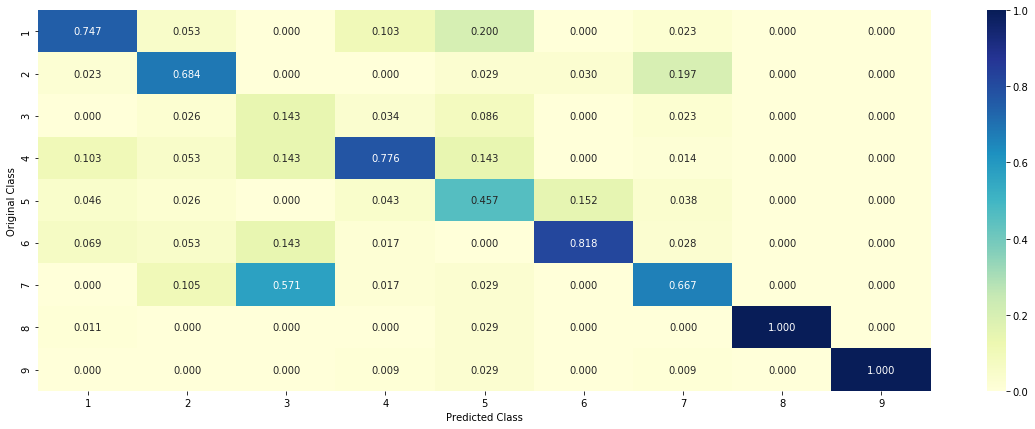

-------------------- Recall matrix (Row sum=1) --------------------


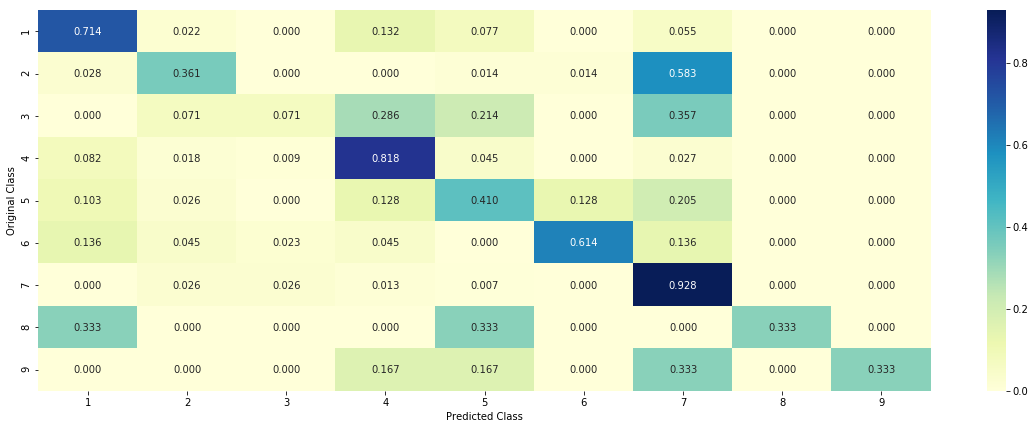

In [51]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_df, y_train, cv_df, y_cv, clf)

<h2>5.1.5 Random Forest </h2>

In [53]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_df, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_df, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_df)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.125582269977826
for n_estimators = 100 and max depth =  10
Log Loss : 1.0789512826687417
for n_estimators = 200 and max depth =  5
Log Loss : 1.1064117590737437
for n_estimators = 200 and max depth =  10
Log Loss : 1.0720564230273837
for n_estimators = 500 and max depth =  5
Log Loss : 1.0825328059025725
for n_estimators = 500 and max depth =  10
Log Loss : 1.0677523675299758
for n_estimators = 1000 and max depth =  5
Log Loss : 1.0707192200134976
for n_estimators = 1000 and max depth =  10
Log Loss : 1.0648064279039207
for n_estimators = 2000 and max depth =  5
Log Loss : 1.0680025549700218
for n_estimators = 2000 and max depth =  10
Log Loss : 1.0664719116574994
For values of best estimator =  1000 The train log loss is: 0.5685065345208199
For values of best estimator =  1000 The cross validation log loss is: 1.0648064279039207
For values of best estimator =  1000 The test log loss is: 1.0737246963152336


Log loss : 1.0648064279039207
Number of mis-classified points : 0.33458646616541354
-------------------- Confusion matrix --------------------


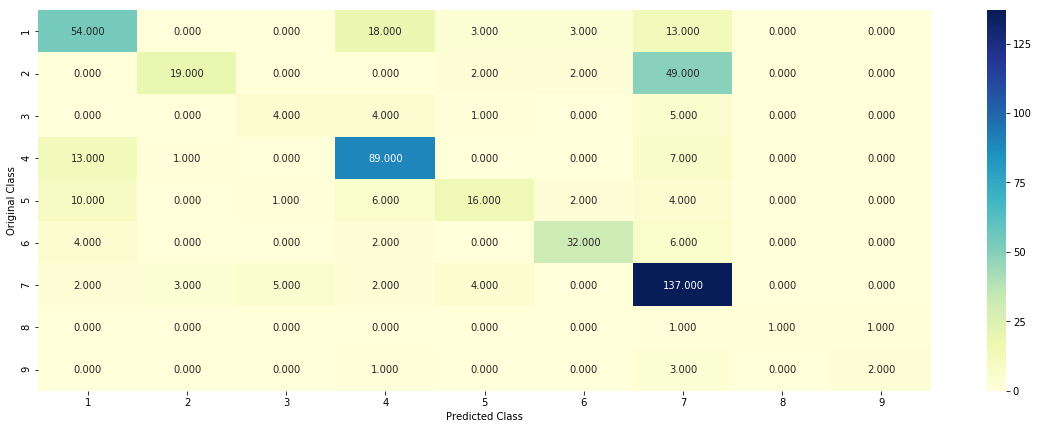

-------------------- Precision matrix (Columm Sum=1) --------------------


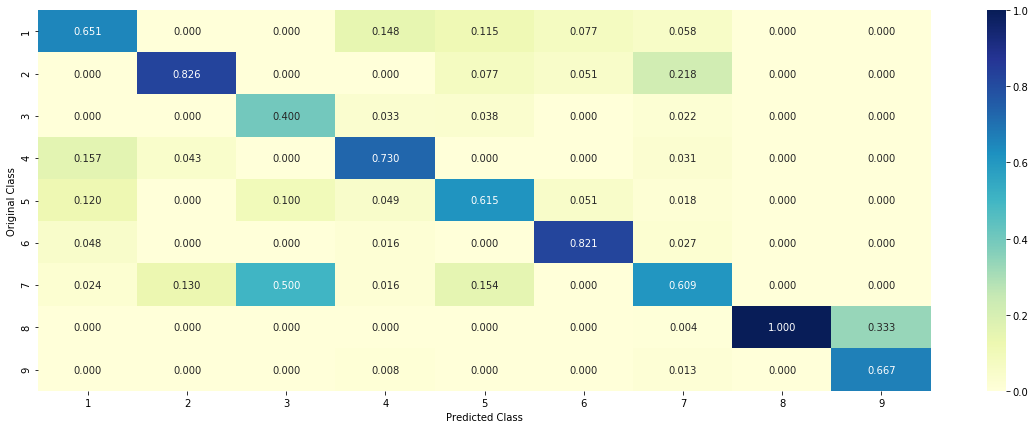

-------------------- Recall matrix (Row sum=1) --------------------


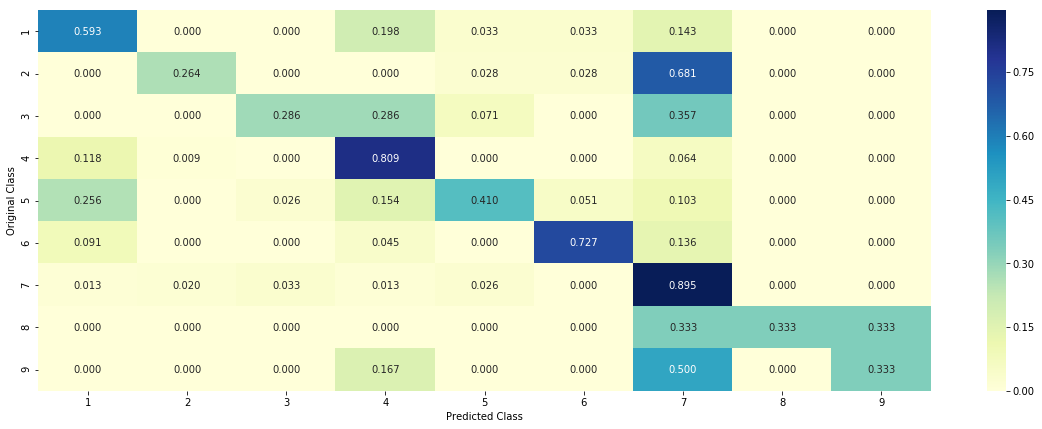

In [54]:

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_df,y_train,cv_df,y_cv, clf)

<html>
<head>
<style>
table, th, td {
    border: 1px solid black;
    border-collapse: collapse;
}
th, td {
    padding: 5px;
}
th {
    text-align: left;
}
</style>
</head>
<body>


<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Log-Loss_on_Train_Dataset</th> 
    <th>Log-Loss_on_CV_Dataset</th>
     <th>Log-Loss_on_test_Dataset</th>
      <th>Misclassification_percentage</th>
  </tr>
  
  <tr>
    <td>K-NN</td>
    <td>0.76</td>
    <td>1.05</td>
     <td>1.07</td>
     <td>38.7</td>
  </tr>
  <tr>
    <td>Logistic Regression with Class Balancing</td>
    <td>0.46</td>
    <td>0.95</td>
     <td>0.92</td>
     <td>31.01</td>
   </tr>
    
   <tr>
    <td>Logistic Regression without Class Balancing</td>
    <td>0.45</td>
    <td>0.95</td>
     <td>0.92</td>
     <td>31.3</td>
    </tr>
    
    <tr>
    <td>Logistic Regression without Class Balancing and L1 penalty</td>
    <td>0.54</td>
    <td>0.99</td>
     <td>0.98</td>
     <td>30.4</td>
    </tr>
    
    <tr>
    <td>Random Forest</td>
    <td>0.56</td>
    <td>1.06</td>
     <td>1.07</td>
     <td>33.4</td>
    </tr>
    
    
</body>
</html>


<h1> Summary </h1>

<p>1. Our Objective was to reduce log_loss on Cv and test dataset less than 1.0.</p>
<p>2. Gene and Variation is a categorical data  so I converted categorical data to Numerical data using</p>
<p>3.  For The Text data I used Tf-Idf and then for dimensionality reduction I used TruncatedSVD</p>
<p>4. The Best Model For this dataset is Logistic Regression With Class balancing </p>


<h6> Submitted By : Dheeraj Khanna </h6>